In [2]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms

import torch.nn.functional as F
import numpy as np
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
INPUT_SHAPE = (784,)
pop_size = 10
generations = 5
# l = [784, 500, 250, 100, 50]
# l = [784, 500]
# init = glorot_uniform(seed = 12)
epochs_FineTune = 3

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 32
lr = 0.01
device = torch.device("cpu")
data_path = "../data"

In [4]:
train_dataset = datasets.MNIST(root=data_path, train= True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_path, train= False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=True)

5


60000

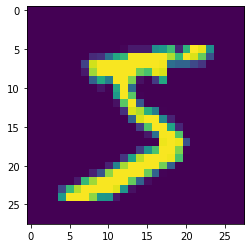

In [5]:
plt.imshow(  train_dataset[0][0].squeeze()  )
print(train_dataset[0][1])
len(train_dataset)

In [ ]:
class GeneticAutoEncoder(nn.Module):
    def __init__(self, layers_size, nonlinearity=torch.tanh):
        super(GeneticAutoEncoder, self).__init__()
        self.layers_size = layers_size
        self.activation_fn = nonlinearity
        # check layer size
        self.input_kernel = nn.Linear(in_features=self.layers_size[0], out_features=self.layers_size[1], bias=False)
        self.train_layer = self.input_kernel 

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.train_layer.weight.data)

    def default_hidden(self, input):
        return input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

    def forward(self, input, hidden):
        input = self.input_kernel(input)
        hidden = self.recurrent_kernel(hidden)
        out = input + hidden
        out = self.nonlinearity(out)

        return out, out

In [76]:
class TiedLinearLayer(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.param = nn.Parameter(torch.zeros(out, inp))
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.param)

    def forward(self, input, transpose):
        if transpose is False:
            output = F.linear(input, self.param)
        else:
            output = F.linear(input, self.param.t())
        return output
    
class SingleTiedAutoEncoder(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.layers = TiedLinearLayer(inp,out)

    def forward(self, input):
        x = torch.flatten(input, start_dim=1) 
        x = self.layers(x, transpose = False) 
        x = self.layers(x, transpose = True)
        return x
    
class TiedAutoEncoder(nn.Module):
    def __init__(self, shape_list, nonlinearity=torch.relu):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nonlinearity = nonlinearity
            
        for i in range(len(shape_list)-1):
            self.layers.append(TiedLinearLayer(shape_list[i],shape_list[i+1]))

    def forward(self, input):
        x = torch.flatten(input, start_dim=1) 
        #encode
        for layer in self.layers:
            x = layer(x, transpose = False)
            x = self.nonlinearity(x)
        encoded_feats = x.detach().clone()
        #decode
        for i, layer in sorted( enumerate(self.layers), reverse=True ):
            x = layer(x, transpose = True)
            if i < len(self.layers)-1:
                x = self.nonlinearity(x)
        reconstructed_output = x
        return encoded_feats, reconstructed_output
    
def train(model, device, train_loader, optimizer, epoch, loss_fn=F.mse_loss):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        encoded_feats, reconstructed_output  = model(data)
#         reconstructed_output  = model(data)
        target = torch.flatten(data, start_dim=1)
        loss = loss_fn(reconstructed_output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [77]:
model = TiedAutoEncoder(shape_list = [784, 500, 250, 100, 50], nonlinearity =torch.relu)
model = TiedAutoEncoder(shape_list = [784, 500], nonlinearity =torch.relu)
# model = SingleTiedAutoEncoder(784,500)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
mae_loss = nn.L1Loss()
# scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, 5):
    train(model, device, train_loader, optimizer, epoch, loss_fn = F.mse_loss)
    # test(model, device, test_loader)
    # scheduler.step()

# if args.save_model:
    # torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.091265
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.057164
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.049032
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.042027
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.040352
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.040841
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.039814
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.039392


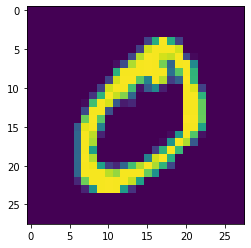

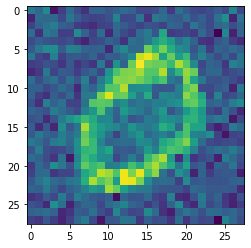

In [80]:
data_sample = train_dataset[1][0]
plt.imshow(data_sample.squeeze())
plt.show()
encoded_feats, reconstructed_output = model(data_sample)
# reconstructed_output = model(data_sample)
plt.imshow(reconstructed_output.detach().numpy().reshape(28,28) )
plt.show()

In [63]:
len(l)

5